### Variational Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import re

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils

![](https://qph.fs.quoracdn.net/main-qimg-62c793e38456b093cd83fd5476aed596)

In [2]:
# Gaussian as encoder
def gaussian_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0
        h0 = tf.nn.elu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)
        
        print("h1 :{}".format(h1.shape))
        # output layer                                                                                                                                                                      
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo
        
        print("gaussian_params: {}".format(gaussian_params.shape))
        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])
        print("gaussian encoder mean:{} n_output:{}".format(mean.shape,n_output))

    return mean, stddev



![](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs10115-018-1306-7/MediaObjects/10115_2018_1306_Fig3_HTML.png)

### decoder
- decoder output loss function follows bernoulli distribution 

In [3]:
# Bernoulli as decoder
def bernoulli_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
        y = tf.sigmoid(tf.matmul(h1, wo) + bo)

    return y


### build autoencoder- encoder

## ELBO term
![](https://image.slidesharecdn.com/iaf-170120100642/95/improving-variational-inference-with-inverse-autoregressive-flow-2-638.jpg?cb=1484906842)

![](./pictures/KL_div.png)

![](./pictures/reconstruction_error.png)

![](./pictures/loss_function1.png)

![](./pictures/gaussian_loss.png)

![](./pictures/gaussian+bernoulli.png)

![](./pictures/gaussian_gaussian.png)

![](./pictures/mnist.png)

In [4]:
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):

    # encoding
    mu, sigma = gaussian_encoder(x_hat, n_hidden, dim_z, keep_prob)
    print("mu:{} sigma:{}".format(mu.shape,sigma.shape))
    # sampling by re-parameterization technique
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
    print("encoder output z:{}".format(z.shape))
    
    # decoding
    y = bernoulli_decoder(z, n_hidden, dim_img, keep_prob)
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
    print("decoder output y:{}".format(y.shape))
    # loss
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO

    return y, z, loss, -marginal_likelihood, KL_divergence


In [5]:

def decoder(z, dim_img, n_hidden):

    y = bernoulli_decoder(z, n_hidden, dim_img, 1.0, reuse=True)

    return y

### setting parameters

In [6]:
RESULTS_DIR = './results'

# network architecture
ADD_NOISE = True # Denoising Auto encoder

n_hidden = 500

IMAGE_SIZE_MNIST = 28

dim_img = IMAGE_SIZE_MNIST**2  # number of pixels for a MNIST image ,784
dim_z = 2#20 # latent vector size

# train
n_epochs = 20
batch_size = 128
learn_rate = 1e-3

# Plot
PRR = True                           # Plot Reproduce Result
PRR_n_img_x = 10              # number of images along x-axis in a canvas
PRR_n_img_y = 10              # number of images along y-axis in a canvas
PRR_resize_factor = 1.0  # resize factor for each image in a canvas

PMLR = True                            # Plot Manifold Learning Result
PMLR_n_img_x = 50            # number of images along x-axis in a canvas
PMLR_n_img_y = 50            # number of images along y-axis in a canvas
PMLR_resize_factor = 1.0   # resize factor for each image in a canvas
PMLR_z_range = 2.0            # range for random latent vector
PMLR_n_samples = 5000        # number of labeled samples to plot a map from input data space to the latent space


In [7]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()
n_samples = train_size

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### build network

In [8]:
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

# network architecture
y, z, loss, neg_marginal_likelihood, KL_divergence = autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)


h1 :(?, 500)
gaussian_params: (?, 4)
gaussian encoder mean:(?, 2) n_output:2
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder output y:(?, 784)


In [10]:
# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = decoder(z_in, dim_img, n_hidden)


z shape:(2500, 2)
self.z [[2.         2.        ]
 [2.         1.91836735]
 [2.         1.83673469]
 [2.         1.75510204]
 [2.         1.67346939]
 [2.         1.59183673]
 [2.         1.51020408]
 [2.         1.42857143]
 [2.         1.34693878]
 [2.         1.26530612]]


epoch 0: L_tot 234.72 L_likelihood 230.58 L_divergence 4.14
epoch 1: L_tot 207.63 L_likelihood 201.35 L_divergence 6.28
epoch 2: L_tot 185.27 L_likelihood 181.39 L_divergence 3.88
epoch 3: L_tot 185.95 L_likelihood 181.54 L_divergence 4.41
epoch 4: L_tot 182.24 L_likelihood 178.13 L_divergence 4.11
epoch 5: L_tot 181.75 L_likelihood 177.62 L_divergence 4.13
epoch 6: L_tot 177.36 L_likelihood 172.90 L_divergence 4.46
epoch 7: L_tot 183.51 L_likelihood 179.45 L_divergence 4.06
epoch 8: L_tot 175.50 L_likelihood 170.87 L_divergence 4.63
epoch 9: L_tot 175.17 L_likelihood 170.67 L_divergence 4.50
epoch 10: L_tot 178.88 L_likelihood 174.29 L_divergence 4.58
epoch 11: L_tot 171.37 L_likelihood 166.71 L_divergence 4.66
epoch 12: L_tot 168.70 L_likelihood 164.18 L_divergence 4.53
epoch 13: L_tot 176.41 L_likelihood 171.84 L_divergence 4.58
epoch 14: L_tot 174.23 L_likelihood 169.21 L_divergence 5.02
epoch 15: L_tot 174.12 L_likelihood 169.41 L_divergence 4.70
epoch 16: L_tot 169.48 L_likelihoo

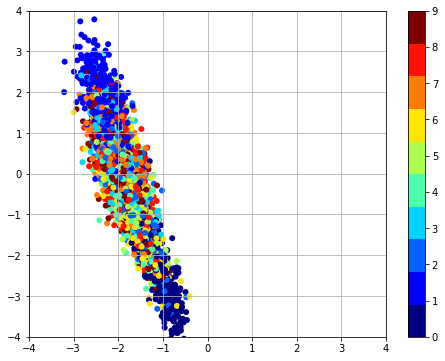

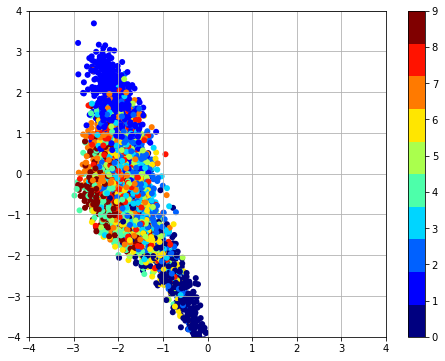

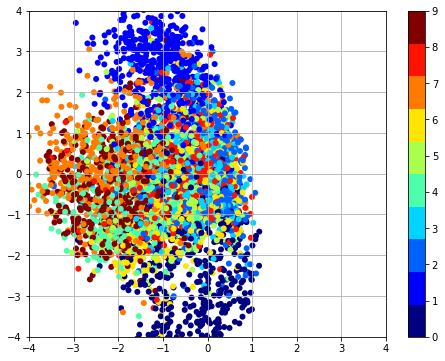

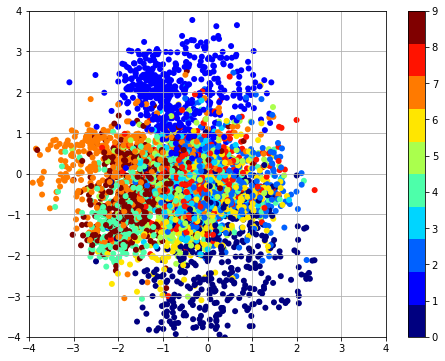

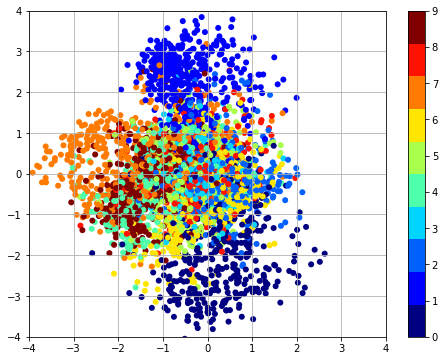

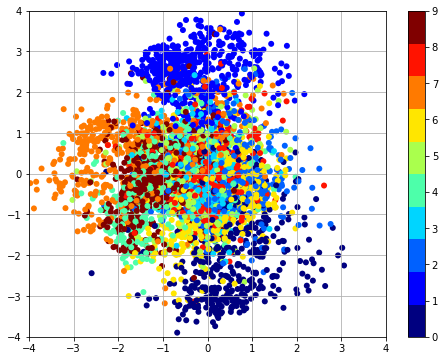

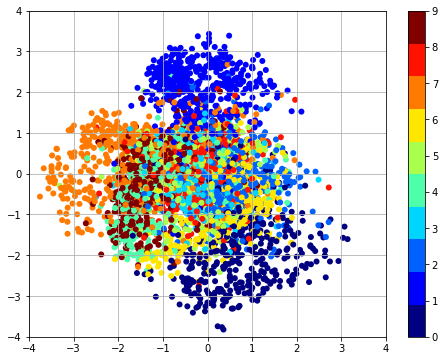

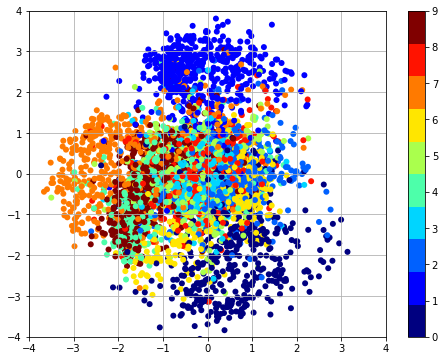

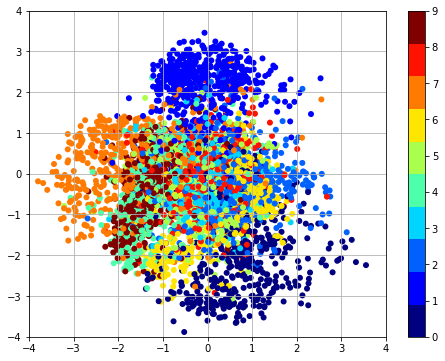

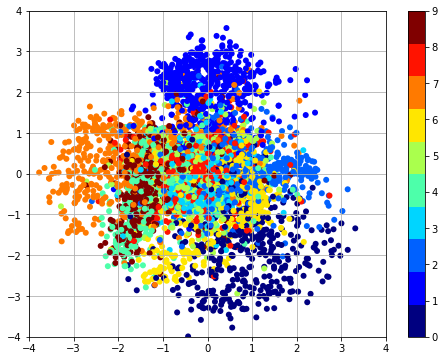

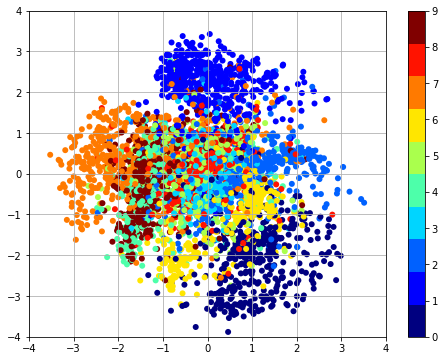

In [11]:

# train
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})
    
        
    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] # (n_samples,784)

        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]

            batch_xs_target = batch_xs_input

            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (train_op, loss, neg_marginal_likelihood, KL_divergence),
                feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))
        
        
        # if minimum loss is updated or final epoch, plot results
        if min_tot_loss > tot_loss or epoch+1 == n_epochs:
            min_tot_loss = tot_loss
            # Plot for reproduce performance
            if PRR:
                y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
                y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

            # Plot for manifold learning result
            if PMLR and dim_z == 2:
                y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
                y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

                # plot distribution of labeled images
                z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
                PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")
    
    model_name = "vae.model"
                
    model_logs_dir = './model'
    if not os.path.exists(model_logs_dir):
        os.makedirs(model_logs_dir)

    saver.save(sess,os.path.join(model_logs_dir, model_name))

#### restore network and test

logs_dir ./model
ckpt_name:vae.model
INFO:tensorflow:Restoring parameters from ./model/vae.model
PMLR.z: [[ 0.          0.        ]
 [ 0.         -0.02040816]]
input:x_PMLR: (5000, 784) z_PMLR: (5000, 2)


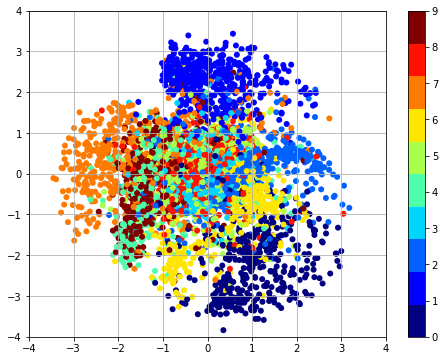

In [14]:
saver = tf.train.Saver(max_to_keep=1)
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})
    
    ckpt_dir = './model'
    print('logs_dir {}'.format(ckpt_dir))
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        print("ckpt_name:{}".format(ckpt_name))
        saver.restore(sess, os.path.join(ckpt_dir, ckpt_name))
    else:
        print(" [*] Failed to find a " +ckpt_dir+ " checkpoint")
    
    if PMLR and dim_z == 2:
        epoch = 0
        
        PMLR.z = np.rollaxis(np.mgrid[0:-1:50j, 0:-1:50j], 0, 3)
        PMLR.z = PMLR.z.reshape([-1, 2])
        print("PMLR.z: {}".format(PMLR.z[:2]))
        y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
        y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

        # plot distribution of labeled images
        z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
        print("input:x_PMLR: {} z_PMLR: {}".format(x_PMLR.shape,z_PMLR.shape))
        PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")

### Analysis of Manifold 

In [23]:
print("latent space input z:{}".format(PMLR.z.shape))
print("decoder output:{}".format(y_PMLR.shape))
print("{} {} {}".format(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST))

latent space input z:(400, 2)
decoder output:(400, 784)
400 28 28


In [36]:
print("encoder output z :{}".format(z_PMLR.shape))
print("{}".format(z_PMLR[:10]))

encoder output z :(5000, 2)
[[-1.4174904  -2.688801  ]
 [ 0.36060664  1.1589129 ]
 [-2.4821954   1.4156163 ]
 [ 2.0285034   0.91552675]
 [ 0.77429926 -1.9049628 ]
 [-1.2589011   0.09625153]
 [-0.19069904 -1.6125634 ]
 [ 0.76673466 -1.3454555 ]
 [ 0.14305732  0.88963723]
 [-1.3576418  -1.2529677 ]]


In [15]:
print("PMLR.n_img_x:{} ,PMLR.n_img_y:{} {}".format(PMLR.n_img_x ,PMLR.n_img_y, PMLR.n_tot_imgs))
print("PMLR_n_samples:{}".format(PMLR_n_samples))
print("test_data:{}".format(test_data.shape))
print("x_PMLR {} id_PMLR {}".format(x_PMLR.shape,id_PMLR.shape))

print("latent space z:{}".format(PMLR.z.shape))

# print("latent z[:10] {}".format(PMLR.z[:10]))
print("z_in {}".format(z_in))
print("dim_img:{} n_hidden:{} dim_z:{}".format(dim_img,n_hidden,dim_z))
# x_PMLR = test_data[0:PMLR_n_samples, :]
# id_PMLR = test_labels[0:PMLR_n_samples, :]

# if ADD_NOISE:
#     x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
#     x_PMLR += np.random.randint(2, size=x_PMLR.shape)

# decoded = decoder(z_in, dim_img, n_hidden)


PMLR.n_img_x:20 ,PMLR.n_img_y:20 400
PMLR_n_samples:5000
test_data:(10000, 784)
x_PMLR (5000, 784) id_PMLR (5000, 10)
latent space z:(400, 2)
z_in Tensor("latent_variable:0", shape=(?, 2), dtype=float32)
dim_img:784 n_hidden:500 dim_z:2


### Scratch

In [34]:
np.random.randint(2, size=batch_xs_input.shape)[:10]

array([[0, 1, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 0]])

In [17]:
train_total_data.shape,test_data.shape,test_labels.shape,mnist_data.NUM_LABELS

((55000, 794), (10000, 784), (10000, 10), 10)

In [22]:
z_range = 2
n_img_y = 20
n_img_x = 20

z = np.rollaxis(np.mgrid[z_range:-z_range:n_img_y * 1j, z_range:-z_range:n_img_x * 1j], 0, 3)

In [23]:
z.shape

(20, 20, 2)

In [25]:
z = z.reshape([-1, 2])
z.shape

(400, 2)

In [27]:
z[:10]

array([[2.        , 2.        ],
       [2.        , 1.78947368],
       [2.        , 1.57894737],
       [2.        , 1.36842105],
       [2.        , 1.15789474],
       [2.        , 0.94736842],
       [2.        , 0.73684211],
       [2.        , 0.52631579],
       [2.        , 0.31578947],
       [2.        , 0.10526316]])

In [52]:
mgrid = np.mgrid[2:-2:10 * 1j, 2:-2:10 * 1j]
gridx,gridy = np.mgrid[2:-2:10 * 1j, 2:-2:10 * 1j]
mgrid.shape
# gridx.shape
mgrid


array([[[ 2.        ,  2.        ,  2.        ,  2.        ,
          2.        ,  2.        ,  2.        ,  2.        ,
          2.        ,  2.        ],
        [ 1.55555556,  1.55555556,  1.55555556,  1.55555556,
          1.55555556,  1.55555556,  1.55555556,  1.55555556,
          1.55555556,  1.55555556],
        [ 1.11111111,  1.11111111,  1.11111111,  1.11111111,
          1.11111111,  1.11111111,  1.11111111,  1.11111111,
          1.11111111,  1.11111111],
        [ 0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.66666667,  0.66666667,  0.66666667,  0.66666667,
          0.66666667,  0.66666667],
        [ 0.22222222,  0.22222222,  0.22222222,  0.22222222,
          0.22222222,  0.22222222,  0.22222222,  0.22222222,
          0.22222222,  0.22222222],
        [-0.22222222, -0.22222222, -0.22222222, -0.22222222,
         -0.22222222, -0.22222222, -0.22222222, -0.22222222,
         -0.22222222, -0.22222222],
        [-0.66666667, -0.66666667, -0.66666667, -0.6

In [49]:
x1, y1 = np.meshgrid(np.arange(1, 6, 2), np.arange(-10, -3, 3))

In [55]:
x1

array([[1, 3, 5],
       [1, 3, 5],
       [1, 3, 5]])

In [51]:
y1.shape

(3, 3)

In [8]:
x2, y2 = np.mgrid[1:11:2, -10:-1:2]

In [17]:
x2,x2.shape

(array([[ 1.,  1.,  1.],
        [ 6.,  6.,  6.],
        [11., 11., 11.]]), (3, 3))

In [18]:
y2,y2.shape

(array([[-10. ,  -5.5,  -1. ],
        [-10. ,  -5.5,  -1. ],
        [-10. ,  -5.5,  -1. ]]), (3, 3))

In [23]:
x2, y2 = np.mgrid[1:11:3j, -10:-1:3j]
testgrid = np.mgrid[1:11:3j, -10:-1:3j]
testgrid.shape

(2, 3, 3)

In [48]:
import numpy as np 
a = np.arange(8).reshape(2,2,2) 

print ('The original array:' )
print (a.shape) 
print ('\n')
# to roll axis-2 to axis-0 (along width to along depth) 

print ('After applying rollaxis function:' )
print (np.rollaxis(a,2,1).shape)
# to roll axis 0 to 1 (along width to height) 
print ('\n' )

# print ('After applying rollaxis function:' )
# print (np.rollaxis(a,2,1))

The original array:
(2, 2, 2)


After applying rollaxis function:
(2, 2, 2)




In [49]:
a = np.ones((1,2,3, 4, 5))
print(a.shape)
print(np.rollaxis(a, 0, 5).shape)

(1, 2, 3, 4, 5)
(2, 3, 4, 5, 1)


[numpy meshgrid mgrid](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)  
[mgrid manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html)

In [ ]:
# sess = tf.InteractiveSession()

In [14]:
# tmpy = tf.constant(-0.4)
# tmpout = tf.clip_by_value(tmpy, 1e-8, 1 - 1e-8)

# sess.run(tmpout)

1e-08

### references
variational autoencoder from https://github.com/hwalsuklee/tensorflow-mnist-VAE